In [1]:
# import modules
import notebook_utils, utils, SLT
# import packages
import numpy as np, matplotlib.pyplot as plt, torch, scipy

seed = 0 # To reproduce results, change this to generate different ensembles

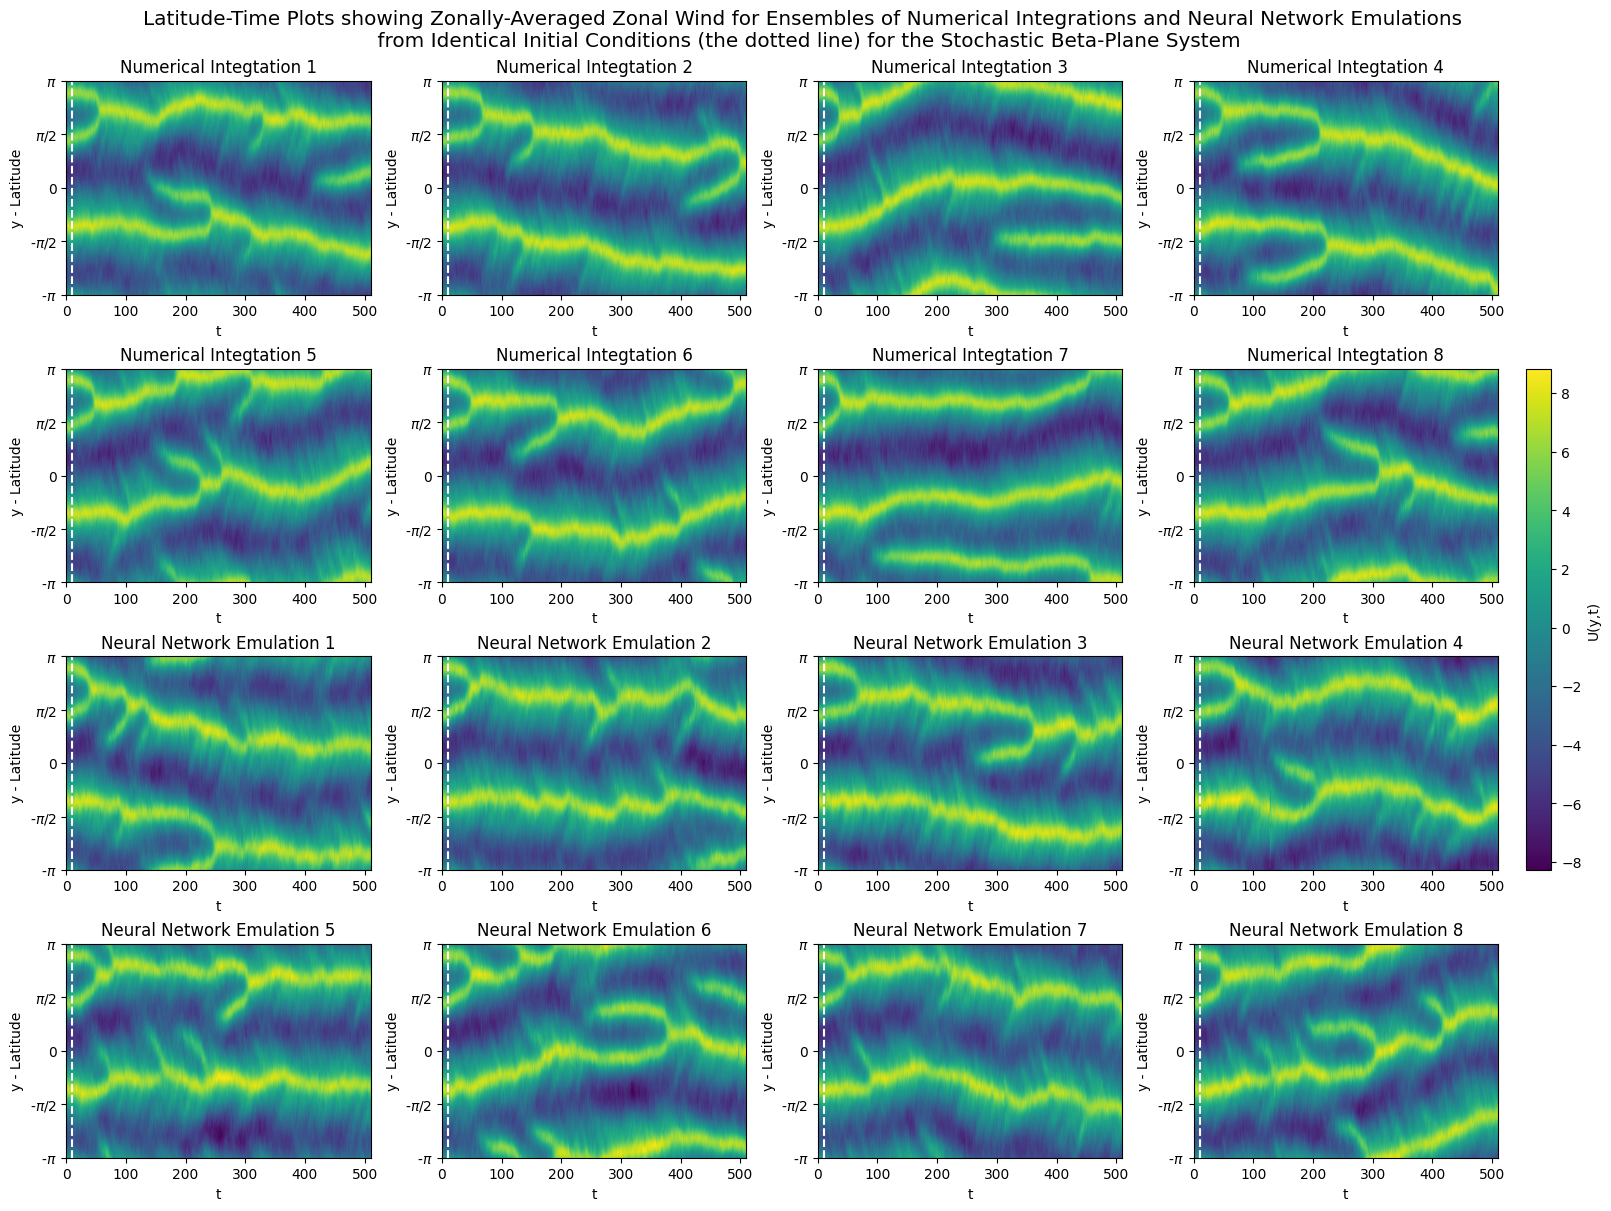

In [2]:
BATCH_SIZE    = 200;
EPOCHS        = 200;
LEARNING_RATE = 2e-3;
LATENT_DIM    = 64; 
SEQ_LENGTH    = 10;
SEQ_FORWARD   = 1;
ENS_SIZE      = 4;
S_WEIGHT      = 0;
RUN_NUM       = 6; 
LAYERS        = 2;
SWEEP         = False;
EVOLUTION_TIME = 500

time_step_start = 100
ensemble_size   = 8
truth_ens       = utils.truth_ensemble(SEQ_LENGTH, EVOLUTION_TIME, ensemble_size, time_step_start)

AE                        = SLT.load_model('AE'   , LATENT_DIM, 0, EPOCHS, RUN_NUM)
RNN                       = SLT.load_model('Trans', LATENT_DIM, 0, EPOCHS, RUN_NUM)
truth_ens, preds_ens, att = SLT.SLT_prediction_ensemble(
    AE, RNN, SEQ_LENGTH, LATENT_DIM, truth_ens, EVOLUTION_TIME, seed
    )
utils.plot_ensembles(truth_ens, preds_ens, seq_len=SEQ_LENGTH, damping_time=False, show=True)

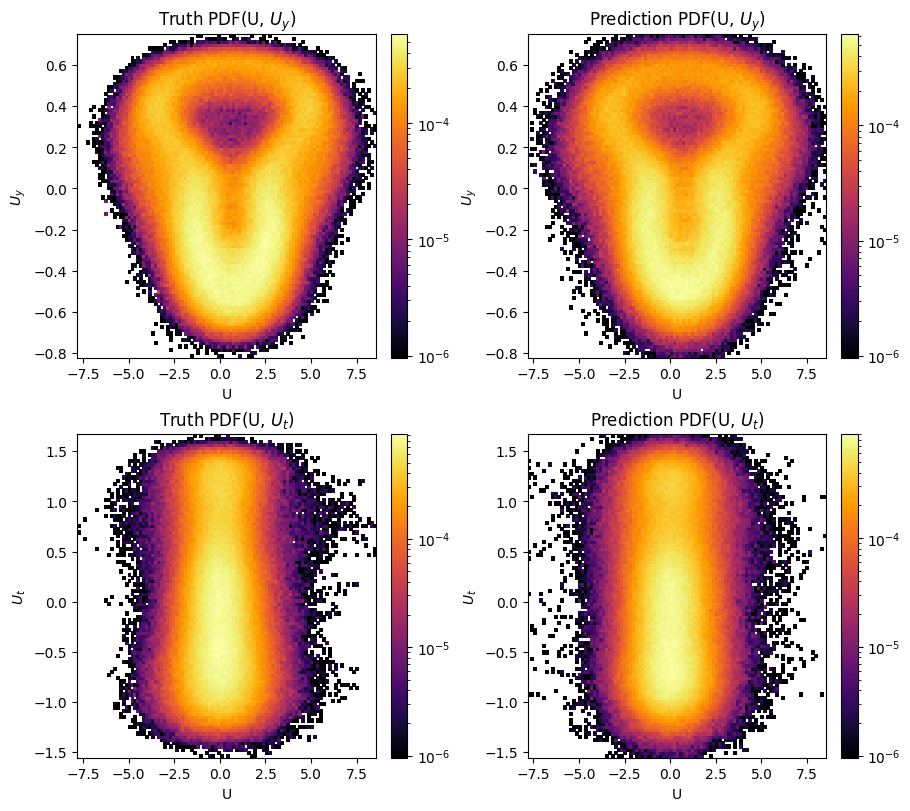

In [3]:
truth_mat, preds_mat = utils.calculate_grad_fields(truth_ens, preds_ens)
p, q, e              = utils.calculate_pdfs(truth_mat, preds_mat)
utils.plot_pdf(p, q, e)
distance = utils.calculate_1D_pdfs(truth_mat, preds_mat, nbins=150)[3]

(0.0, 500.0)

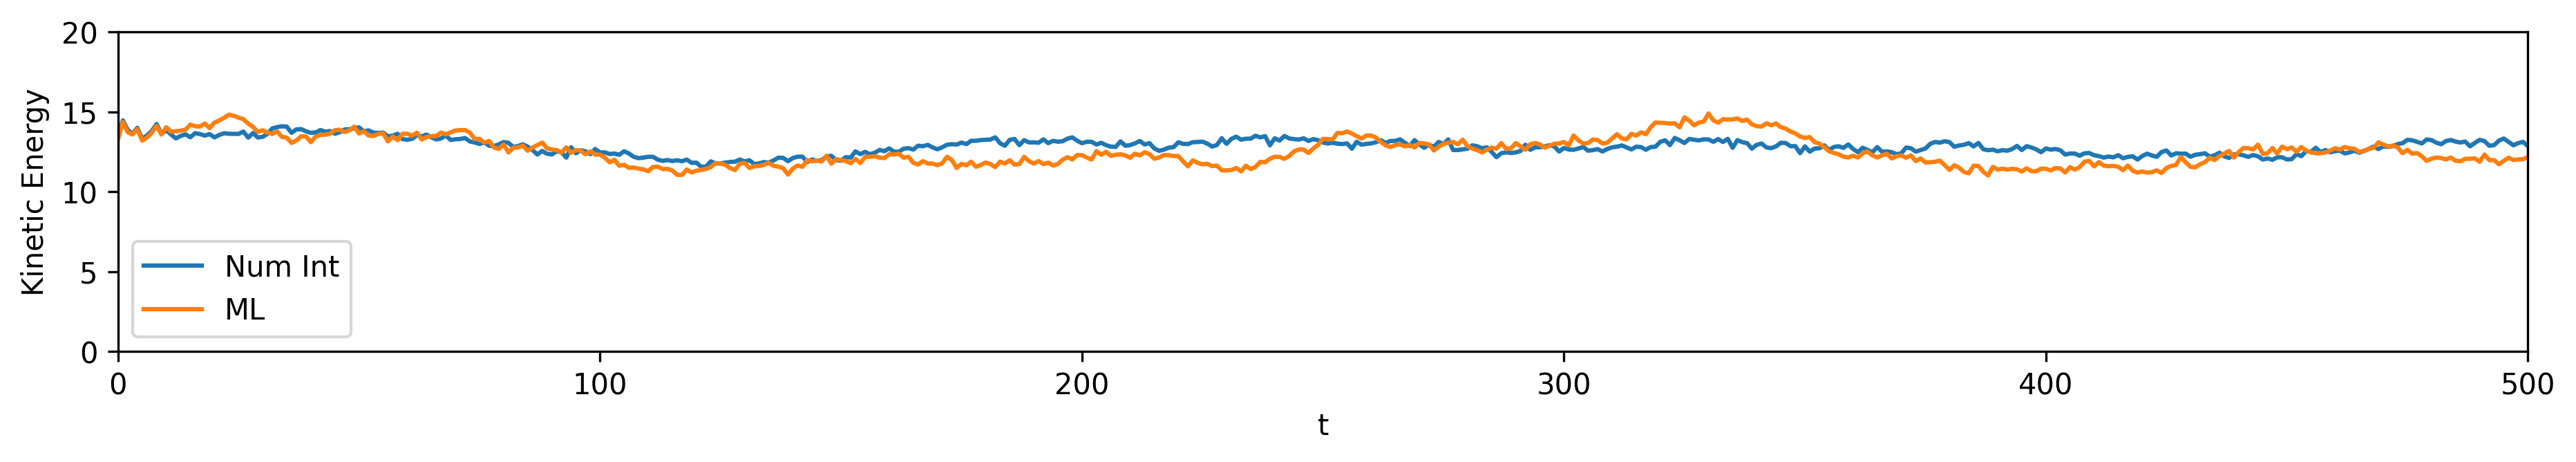

In [8]:
truth_ens_energy = torch.mean(torch.mean(truth_ens**2, dim=-1), dim=0)
preds_ens_energy = torch.mean(torch.mean(preds_ens**2, dim=-1), dim=0)

plt.figure(figsize=(15, 2), dpi=300)
plt.plot(truth_ens_energy, label='Num Int')
plt.plot(preds_ens_energy, label='ML' )
plt.ylabel('Kinetic Energy')
plt.xlabel('t')
plt.legend()
plt.ylim(0, 20)
plt.xlim(0, 500)

In [ ]:
truth_ens = utils.truth_ensemble(1, 100, 1, 100)

def shift_phase(z):

    z   = torch.fft.rfft(z, norm='ortho')
    N = z.size(-1)
    k = torch.linspace(-(N-1)//2, (N-1)//2, N)
    k = torch.cat((k[(N-1)//2:], k[:(N-1)//2]))
    phi = torch.angle(z[...,1])
    phi = torch.einsum('i,k->ik', phi, k)
    z   = z * torch.exp(-1j*phi)
    z   = torch.fft.irfft(z, norm='ortho')
    return z

a = AE.Encoder(truth_ens[0, 10].unsqueeze(0))[0]
b = AE.Encoder(torch.roll(truth_ens[0, 10], 128).unsqueeze(0))[0]

a = shift_phase(AE.Encoder(truth_ens[0, 10].unsqueeze(0)))[0]
b = shift_phase(AE.Encoder(torch.roll(truth_ens[0, 10], 24).unsqueeze(0)))[0]

plt.plot(a.detach().numpy(), label='z_')
plt.plot(b.detach().numpy(), label='z__')
plt.legend()
plt.show()

In [ ]:
for j in range(1):
    truth_ens                 = utils.truth_ensemble(SEQ_LENGTH, EVOLUTION_TIME, ensemble_size, time_step_start)
    #AE                        = utils.load_model('AE' , ARCH, LATENT_DIM, 0, EPOCHS, RUN_NUM, best=False)
    #RNN                       = utils.load_model('RNN', ARCH, LATENT_DIM, 0, EPOCHS, RUN_NUM, best=False)
    #truth_ens, preds_ens, att = utils.prediction_ensemble(AE, RNN, SEQ_LENGTH, LATENT_DIM, truth_ens, 500)
    crps_ , mse_ , rep_       = utils.CRPS(preds_ens[1:], truth_ens[0])
    crps_t, mse_t, rep_t      = utils.CRPS(truth_ens[1:], truth_ens[0])

    mosaic = """ab
            cd"""
    fig, axs = plt.subplot_mosaic(mosaic, layout='constrained', dpi=400)
    fig.set_size_inches(4.7*2, 3.5*2)

    Ulabel = ['U', r'$\partial U /\partial y$', r'$\partial U /\partial t$']

    for label, ax in axs.items():

        if label=='a':
            ax.plot(mse_ [SEQ_LENGTH+1:] , label=f'SLT', color='red')
            #ax.plot(mse_v[10+1:], label=f'VAE')
            ax.plot(mse_t[SEQ_LENGTH+1:], label=f'Num', color='green')
            ax.set_yscale('log')
            ax.set_title('MAE', fontsize=5.2*2)
            ax.set_xlabel('t', fontsize=5.2*2)
            ax.set_xlim(0, 250)
            ax.legend(fontsize=5.2*2)

        if label=='b':
            ax.plot(rep_ [SEQ_LENGTH+1:], label=f'SLT', color='red')
            #ax.plot(rep_v[10+1:], label=f'VAE')
            ax.plot(rep_t[SEQ_LENGTH+1:], label=f'Num', color='green')
            ax.set_yscale('log')
            ax.set_title('Ensemble Variation', fontsize=5.2*2)
            ax.set_xlabel('t', fontsize=5.2*2)
            ax.set_xlim(0, 250)
            ax.legend(fontsize=5.2*2)

        '''if label=='c':
            ax.plot([64], [0.1, 0.1, 0.1, 0.1, 0.1, 4e-4,  4e-4,  4e-4, 4e-4, 4e-4], 'bo', label='SLT')
            ax.axhline(y=0.01, linestyle='--', color='gray', label='Num')
            ax.set_xscale('log', base=2)
            ax.set_yscale('log')
            ax.set_ylabel("H(p, q)", fontsize=5.2*2)
            ax.set_title("Hellinger Distance", fontsize=5.2*2)
            ax.set_xlabel('Latent Dimention' , fontsize=5.2*2)
            ax.legend()

        if label=='d':
            X = np.arange(2, 5, 1)
            ax.bar(X - 0.25, mat_num[2:5, 0], edgecolor = 'b', width = 0.25, fill=False)
            ax.bar(X + 0.00, mat_num[2:5, 1], edgecolor = 'g', width = 0.25, fill=False)
            ax.bar(X + 0.25, mat_num[2:5, 2], edgecolor = 'r', width = 0.25, fill=False)

            ax.bar(X - 0.25, mat_ml[2:5, 0]*1.35, edgecolor = 'b', width = 0.25, fill=False, linestyle='--')
            ax.bar(X + 0.00, mat_ml[2:5, 1]     , edgecolor = 'g', width = 0.25, fill=False, linestyle='--')
            ax.bar(X + 0.25, mat_ml[2:5, 2]*1.35, edgecolor = 'r', width = 0.25, fill=False, linestyle='--')
            ax.set_ylim(10e-5, 1)

            ax.set_yscale('log')
            ax.set_xlabel('Number of Jets', fontsize=5.2*2)
            ax.set_ylabel('Probability of Transition (log)', fontsize=5.2*2)
            ax.legend(['-1', '0', '+1'], fontsize=5.2*2)
            ax.set_title('Solid: Numerical Integration; Dashed: ML Emulation', fontsize=5.2*2)'''

    plt.show()
